In [1]:
### IMPORTS

import simpy
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(110)


### ENTITY PROCESS
# One train passing which passes through its segment_path, waiting for segments to become available

def train(env, train_id, departure_time, nodepair, segments, segment_paths, verbose1, verbose2):
     
    yield env.timeout(departure_time) #make sure each train start at right time
    
#for each segment in segment paths the train will request the resource    
    for i in range(len(segment_paths[nodepair])):#for an explanation for nodepair look further down
        
        with segment_paths[nodepair][i].request() as req: #this with statement is used to request the resources (segments)
            
            if verbose1:
                print(f'{env.now}: Train {train_id} must wait until {len(segment_paths[nodepair][i].queue)} previous Trains passed through the same segment to get free capacity of its N.{str(i+1)} Segment.')
                
            yield req
            
            if verbose1:
                print(f'{env.now}: Train {train_id} with planning start time {departure_time} recieve request of its N.{i+1} Segment.')
            
            yield env.timeout(passthrough_time) #after the passthrough time the train has passed through the segment
            
            if verbose1:
                print(f'{env.now}: Train {train_id} just pass through its required N.{i+1} Segment')
                
    if verbose2:
        print(f'{env.now}: Train {train_id} pass through its all required {len(segment_paths[nodepair])} segments!!!\n******************************************')
        
    delay = env.now - (departure_time + 15 * len(segment_paths[nodepair])) #this is how we calculated the delay of each train
    delays_dict[train_id] = delay
    delays.append(delay)



### STATIC WORLD INFORMATION

passthrough_time = 15
operation_minutes = 800
n_trains = 500



earliest_dep = np.repeat(np.arange(0,571,30),repeats=n_trains / 20)

def create_segments_and_paths(env,num_parallel_tracks):

    """
    Create ten track segments represented by simpy resources.

    Each track segment has a fixed number of parallel tracks which indicates
    how many trains can be on the segment at the same time.
    The number of parallel tracks is the same across all segments.
    All segments form a list called 'segments'.

    A sequence of segments connects each pair of five stations.
    The dictionary 'segment_paths' describes how each pair of stations
    is connected by a sequence of segments.
    The keys are said pairs of stations and the values are the sequences of segments.

    The function returns the list of segments and the dictionary of segment paths.
    This means that the function returns two values as a tuple.

    It can be used to add resources to the environment 'env'.

    Example:
    segments, segment_paths = create_segments_and_paths(env,2)

    Now, segments is a list of ten simpy resources and segment_paths is a dictionary.
    

    """

    segment1 = simpy.Resource(env, num_parallel_tracks)
    segment2 = simpy.Resource(env, num_parallel_tracks)
    segment3 = simpy.Resource(env, num_parallel_tracks)
    segment4 = simpy.Resource(env, num_parallel_tracks)
    segment5 = simpy.Resource(env, num_parallel_tracks)
    segment6 = simpy.Resource(env, num_parallel_tracks)
    segment7  = simpy.Resource(env, num_parallel_tracks)
    segment8 = simpy.Resource(env, num_parallel_tracks)
    segment9 = simpy.Resource(env, num_parallel_tracks)
    segment10 = simpy.Resource(env, num_parallel_tracks)

    segment_paths = {
        (1, 2): [segment1, segment3, segment5],
        (1, 3): [segment1, segment2, segment4, segment6],
        (1, 4): [segment1, segment7, segment8],
        (1, 5): [segment1, segment9, segment10],
        (2, 3): [segment2, segment4, segment6],
        (2, 4): [segment2, segment5, segment7, segment8],
        (2, 5): [segment2, segment5, segment9, segment10],
        (3, 4): [segment3, segment7, segment8],
        (3, 5): [segment3, segment9, segment10],
        (4, 5): [segment4, segment8, segment9, segment10],
    }
    add_to_dict = {}
    for (start, end), segments in segment_paths.items():
        add_to_dict[(end, start)] = segments[::-1]

    segment_paths.update(add_to_dict)

    segments = [segment1, segment2, segment3, segment4, segment5, segment6, segment7, segment8, segment9, segment10]
    return segments, segment_paths




### RANDOM ENTITTY INFORMATION
# Random start and end points for each of the trains 
# Departure and arrival nodes must not be the same
nodepair_list = []
m = 0
#this while loop creates a tuple of start and end points for each train. The tuples are then stored in a list for further use.
while m < n_trains:
    a = np.random.randint(1,6)
    b = np.random.randint(1,6)
    pairs = (a,b)
    if a!=b:     #this if statement ensures that no train has the same start and end point
        nodepair_list.append(pairs)
        m += 1
#print(nodepair_list) 
#len(nodepair_list)

# create train_id for each train:
train_id =[]
for number in range(1,n_trains+1):
    train_id.append(number)
#print(train_id)



### SCENARIO ANALYSIS

parallel_tracks = list(range(1,21))
mean_delays = []

#first for-loop creates 20 simulation runs with different num_parallel_tracks.    
for num_parallel_tracks in parallel_tracks:
    
    #initialize simpy.Environment() for every new run with certain num_parallel_tracks.
    #to make sure Environment time does not cumulate
    env = simpy.Environment()
    segments, segment_paths = create_segments_and_paths(env,num_parallel_tracks)
    # Create the segments and the segment_paths tuple using the create_segments_and_paths function
    verbose1 = False
    verbose2 = False
    delays_dict = dict()
    delays = []
    task = []
    #this for-loop assigns the different lists we created to the individual trains, pack the corresponding information tuple one by one into train function.
    #And append all tasks one by one into task list.
    for tid,dpt,nop in zip(train_id, earliest_dep, nodepair_list):
        #print(tid,dpt,np)
        task.append(train(env, tid, dpt, nop, segments, segment_paths, verbose1, verbose2))
    #Add each task in process
    for t in task:
        #print(task)
        env.process(t)

    env.run(800)
    print(f'\n+++++++++++++++++++++++++++Finished run with {num_parallel_tracks} of parallel_tracks+++++++++++++++++++++++++++\n')
    print(f'At the end of this run {len(delays)} out of 500 Trains arrived destination!')
    #print(delays)
    #print(len(delays))
    #print(delays_dict)
    mdelays = round(np.array(delays).mean(),2) 
    mean_delays.append(mdelays)
    
print(mean_delays)
#print(len(mean_delays))
mdelays_array = np.array(mean_delays)

    


+++++++++++++++++++++++++++Finished run with 1 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 46 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finished run with 2 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 178 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finished run with 3 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 336 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finished run with 4 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 479 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finished run with 5 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 500 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finished run with 6 of parallel_tracks+++++++++++++++++++++++++++

At the end of this run 500 out of 500 Trains arrived destination!

+++++++++++++++++++++++++++Finishe

In [2]:
import pandas as pd   
tracks_df = pd.DataFrame({'num_of_tracks':parallel_tracks, 'mean_delays':mdelays_array}, index = np.arange(1,21))

low_meandelays = tracks_df[tracks_df['mean_delays']<=30]
print(low_meandelays)
min_numoftracks = low_meandelays['num_of_tracks'].min()
min_numoftracks

    num_of_tracks  mean_delays
6               6         9.51
7               7         5.07
8               8         2.73
9               9         1.62
10             10         1.08
11             11         0.72
12             12         0.45
13             13         0.27
14             14         0.12
15             15         0.03
16             16         0.00
17             17         0.00
18             18         0.00
19             19         0.00
20             20         0.00


6

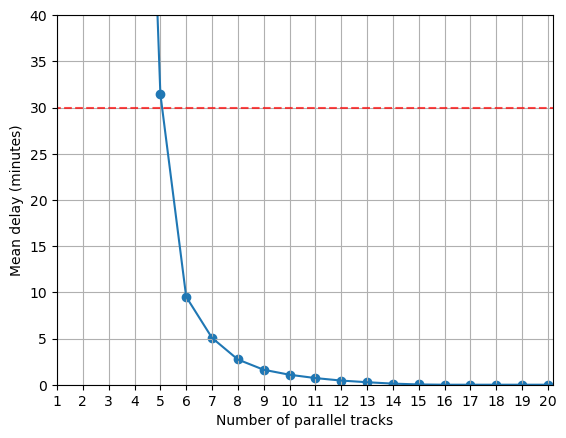

In [4]:
# PLOT RESULTS
plt.plot(parallel_tracks, mean_delays)
plt.scatter(parallel_tracks, mean_delays)
plt.xticks(parallel_tracks)
plt.ylim(0,40)
plt.xlim(1,max(parallel_tracks)+0.2)
plt.hlines(30,0,max(parallel_tracks)+0.2,color='red',ls='--',alpha=0.7)
plt.xlabel('Number of parallel tracks')
plt.ylabel('Mean delay (minutes)')
plt.grid()

# Conclusion:

# The best number of parallel tracks according to our simulation is 6 parallel tracks per segment. 
# This is the number with the least amount of parallel tracks per segment and a mean delay of 10 minutes, which is under 30 minutes
